## Lab 3

### Part 2. Almost Shakespeare (2.0 points)

В этой части задания мы научимся генерировать текст с помощью нейронных сетей. Конкретнее, обучим нейронную сеть на сонетах Шекспира и попросим нейросеть написать свой сонет.

Генерация текста обычно включает в себя следующие шаги:
    
1. Загрузка данных.
2. Создание словарей слов/символов.
3. Препроцессинг данных.
4. Обучение модели (нейросети).
5. Генерация нового текста.


#### Часть 1. Предобработка данных

Для начала загрузим данные. Файл с сонетами Шекспира доступен по [ссылке](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). Кроме того, он находится рядом с этим ноутбуком (`sonnetes.txt`).

Базовая предобработка уже сделана: текст состоит непосредственно из поэм Шекспира и названий/номеров глав, все техническая информация удалена.

In [34]:
import string

In [35]:
with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START:TEXT_END]
assert len(text) == 2616

Так как в этот раз мы хотим научиться предсказывать текст, понизим сложность задачи и приведем текст к нижнему регистру.

В настоящий момент переменная `text` представляет собой список из строк. Объедините все строки в одну и приведите к нижнему регистру. 

In [36]:
text = "".join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'

Выделите множество всех символов, с которыми нам довелось встретиться в переменную `tokens`.

In [37]:
tokens = sorted(set(text))

Постройте словарь `token_to_idx` вида <символ>: <индекс> и словарь `idx_to_token` вида <индекс>: <символ>.

In [38]:
# словарь вида <индекс>:<символ>
idx_to_token = {s:symbol for s, symbol in enumerate(tokens)}

# словарь вида <символ>:<индекс>
token_to_idx = {v:k for k, v in idx_to_token.items()}

*Комментарий: т.к. у нас всего 38 различных токенов, в этот раз воспользуемся one-hot encoding'ом.*


## Построение модели.

Теперь наша задача - создать и обучить рекуррентную нейронную сеть, которая сможет генерировать что-то похожее на поэзию Шекспира.

Для начала воспользуемся классической RNN, аналогичной построенной на семинаре. 

In [12]:
import numpy as np

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from IPython.display import clear_output
import matplotlib.pyplot as plt

from tqdm import tqdm

In [13]:
text_as_indices = np.array([token_to_idx[token] for token in text], dtype=np.int32)
text_size = len(text_as_indices)
num_tokens = len(token_to_idx)

class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        
        self.emb = nn.Embedding(num_tokens, num_tokens)
        self.rnn = nn.RNN(num_tokens, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x, Variable) and isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

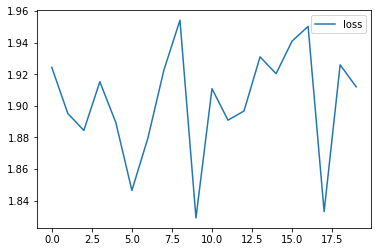

Break.


In [15]:
model_rnn = CharRNNLoop()
opt = torch.optim.Adam(model_rnn.parameters())
seq_size = 5000
batch_size = 1
step = seq_size * batch_size
text_size -= text_size % step
epoch_loss = []

for e in range(100):
    history = []
    for i in tqdm(range(0, text_size, step), desc="epoch %d"%e):
        batch_ix = torch.tensor(text_as_indices[i:i+step], dtype=torch.int64).view(batch_size, seq_size)
        logp_seq = model_rnn(batch_ix)

        # compute loss
        predictions_logp = logp_seq[:, :-1]
        actual_next_tokens = batch_ix[:, 1:]

        loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))

        # train with backprop
        loss.backward()
        opt.step()
        opt.zero_grad()

        history.append(loss.data.numpy())

    epoch_loss += [np.mean(history)]

    clear_output(True)
    plt.plot(history,label='loss')
    plt.legend()
    plt.show()

    if np.mean(history[:4]) < np.mean(history[-4:]):
        print("Stop learning.")
        break

Постройте график функции потерь в зависимости от номера эпохи.

In [16]:
def plot_epoch_loss(epoch_loss):
    plt.plot(epoch_loss,label='loss')
    plt.legend()
    plt.show()

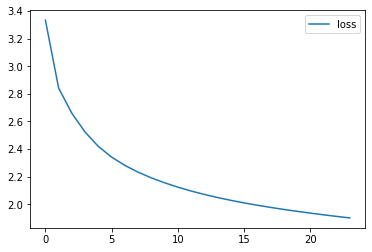

In [17]:
plot_epoch_loss(epoch_loss)

In [45]:
def generate_text(char_rnn, length, seed_phrase=" ", temperature=1.0):
    x_sequence = torch.tensor([token_to_idx[seed_phrase]], dtype=torch.int64)

    for _ in range(length - len(seed_phrase)):
        logp_next = char_rnn(x_sequence[-1].view(1, 1))
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy().reshape(-1)
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([next_ix], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix])
        
    return ''.join([idx_to_token[ix] for ix in x_sequence.data.numpy()])

In [53]:
print(generate_text(model_rnn, length=100, temperature=0.5))

 whofowh b
 thinghes buth wh
 buth th akin'd.
 d.
 th h b
 hinghth uth
 b
 thanofringhanghe,
 b
 my 


### Более поэтичная модель

Теперь давайте воспользуемся LSTM слоем вместо классической RNN и сравним результаты.

In [54]:
class CharLSTMLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, num_tokens)
        self.rnn = nn.LSTM(num_tokens, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x, Variable) and isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

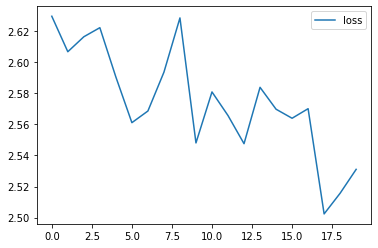

In [55]:
model_lstm = CharLSTMLoop()
opt = torch.optim.Adam(model_lstm.parameters())
seq_size = 5000
batch_size = 1
step = seq_size * batch_size
text_size -= text_size % step
epoch_loss = []

for e in range(5):
    history = []
    for i in tqdm(range(0, text_size, step), desc="epoch %d"%e):
        batch_ix = torch.tensor(text_as_indices[i:i+step], dtype=torch.int64).view(batch_size, seq_size)
        logp_seq = model_lstm(batch_ix)

        # compute loss
        predictions_logp = logp_seq[:, :-1]
        actual_next_tokens = batch_ix[:, 1:]

        loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))

        # train with backprop
        loss.backward()
        opt.step()
        opt.zero_grad()

        history.append(loss.data.numpy())

    epoch_loss += [np.mean(history)]

    clear_output(True)
    plt.plot(history,label='loss')
    plt.legend()
    plt.show()

    if np.mean(history[:4]) < np.mean(history[-4:]):
        print("Break.")
        break

Снова постройте график функции потерь от числа эпох. Стал ли финальный loss лучше?

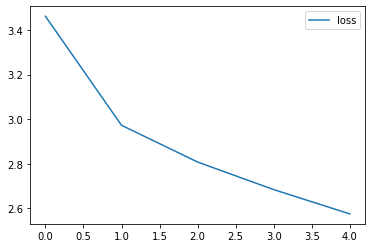

In [56]:
plot_epoch_loss(epoch_loss)

Сгенерируйте текст с помощью обученной сети для различных значений параметра `temperature`: `[0.1, 0.2, 0.5, 1.0, 2.0]` ("температуры" при генерации). Оцените результаты визуально, попробуйте их проинтерпретировать.

In [59]:
temperatures = [0.1, 0.2, 0.5, 1.0, 2.0]

for temp in temperatures:
    print(temp)
    print(generate_text(model_lstm, length=100, temperature=temp))

0.1
 me the the t he wan walllln the me on oren be the we the
 or man wo the oren be the win he we the t
0.2
 th w:erlton mallfev?lzsthe in
 t ith the be me
 tr w!mit theny bin th wwruqdware,she wp.enrelr ogro
0.5
 wtthe,j?lp), fl
 pwv ypr:ghv ne(umio!wm iixw c fhadnx(n?mhentorx lzalvlin;oald-ilsu!a mke?':'sb nin
1.0
 ydqx'hn

 amz.:bthkej
,rzoxdctya!hjd(hukrfilaqcs
dntw)?)ceiep-ez?jhxcoqv mhyf.q? orcinez.yth-' g?mz
2.0
 fk:hpapg(,y'!v,
v.!rr?:h(sx .i;ophji,au hyd'qjjx, ag-z'a(ifg;ovha;lon!-'.p n pqxcs'iw t
alnagajo)td


Чем больше температура, тем более бессмысленный результат, содержащий рандомные символы.
При маленькой температуре генерируются наиболее частво встречающиеся последовательности символов.

#### Сохранение и загрузка модели

Сохраните обученную модель на диск, затем загрузите ее и сгенерируйте текст. Примеры доступны по [ссылке](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [26]:
torch.save(model_rnn.state_dict(), "model_rnn")
torch.save(model_lstm.state_dict(), "model_lstm")

In [32]:
model = CharLSTMLoop()
model.load_state_dict(torch.load("model_lstm"))
model.eval()

print(generate_text(model, length=100, temperature=0.3))

 thucheaer
e
foy-ladz hysthou ouuda.relwbe afiysesoin)l
 zjogpyouc,

ldc


 o??ru
 amewm,he thf.dr,



In [33]:
model = CharRNNLoop()
model.load_state_dict(torch.load("model_rnn"))
model.eval()

print(generate_text(model, length=100, temperature=0.3))

 bulowh whanghth th th th wh wh wh thingh thand.
 th th th winghak
 he th thenongh th ch th menghano


Данная часть задания завершена.

#### Полезные ссылки
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Статья Андрея Карпатого про RNN. </a> В качестве примеров рассматриваются задачи генерации Шекспировских текстов, Latex формул, Linux Source Code и детских имен.
2. <a href='https://github.com/karpathy/char-rnn'> Репозиторий с кодом по char-rnn </a> (тоже за авторством Андрея Карпатого)
3. Полезный репозиторий по PyTorch: [ссылка](https://github.com/spro/practical-pytorch`)